# Dynamic LCA example 

This notebook attempts to illustrate how time-series measurements from sensors of a production line can be used in LCA. These time-series can be used to create time-series of LCA results, differentiating between various products that may be produced with the same machines, and helping to interpret how changes may affect results over time  

In [5]:
import numpy as np
import pandas as pd
import bw2data as bd 
import bw2calc as bc
import bw_processing as bwp
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import copy

In [6]:
bd.projects.set_current('hypercog')
ecoinvent = bd.Database('ei_391con')
gwp100 = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

```mermaid
flowchart TD
A[electricity_production]-->|electricity|B[factory]
B-->|productA|C[consumers]
B-->|productB|C[consumers]
```

Imagine we have a process that produces two products, product A on Monday and Tuesday and product B the rest of the week. It takes less electricity to produce product A. The factory does not operate on weekends and at the beginning of Febrary we've introduced an improvement that reduces the electricity consumption of product A by half. The average daily electricity consumption from our sensors may have looked something like this

In [7]:
date_range = pd.date_range(start='2023-01-01',end='2023-02-28')
data = pd.Series(np.random.normal(loc=8,scale=1,size=len(date_range)),
                 index=date_range).to_frame('electricity')
#data['weekday'] = data.index.weekday
data['dayname'] = data.index.day_name()
data['month_name'] = data.index.month_name()

data.loc[data.dayname.isin(['Monday','Tuesday']),'product'] = 'A'
data.loc[data.dayname.isin(['Wednesday','Thursday','Friday']),'product'] = 'B'

# electricity consumption
data.loc[data.dayname.isin(['Monday','Tuesday']),'electricity'] = \
data.loc[data.dayname.isin(['Monday','Tuesday']),'electricity'] * 0.7

# not working on weekends
data.loc[data.dayname.isin(['Saturday','Sunday']),'electricity'] = 0 

# improvements in production of product A
data.loc[(data.month_name=='February')&(data['product']=='A'),'electricity'] = (
    data.loc[(data.month_name=='February')&(data['product']=='A'),'electricity'] * 0.5)

in this case the data is totally fabricated, but in a real application it would come from sensors

<Axes: >

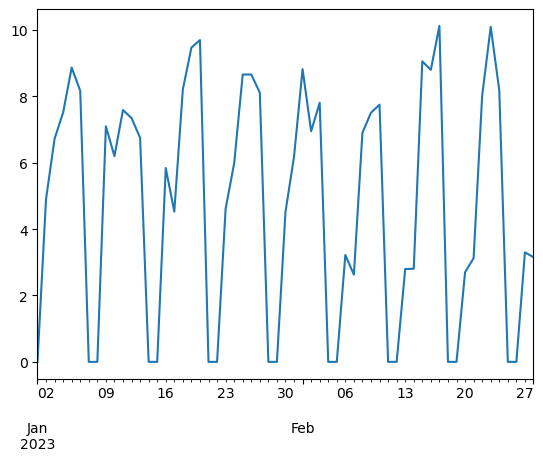

In [8]:
data.electricity.plot()

what is the carbon footprint of product A and product B and how it has changed after our improvement ?

In [9]:
# first we pick up an activity producing electricity from the previous example
example_db = bd.Database('marginal_example')
elec_market = bd.get_node(database='marginal_example',code='elec')

In [12]:
try:
    factory = example_db.get_node(code='factory')
except:
    factory = example_db.new_node(code='factory',name='factory')
    factory.save()
    factory.new_edge(input=elec_market,amount=data.electricity.mean(),type='technosphere').save()

this would be the average global warming score if we do not differentiate between the different products being produced and the difference between before/after the intervention in February

In [13]:
standard_lca = bc.LCA({factory:1},gwp100)
standard_lca.lci()
standard_lca.lcia()
standard_lca.score

2.4391072571542822

## create datapackages

first the indices, that indicates which _edge_ / _exchange_ is being affected. In this case the electricity consumption by the factory. The flip array is true because we are modifying an element of the technosphere matrix and by convention uses are negative

In [14]:
indices_array = np.array([(elec_market.id,factory.id)],dtype =bwp.INDICES_DTYPE)
flip_array = np.array([True]*indices_array.shape[0])

we use our knowledge of when each product is produced to do product subdivision, and divide when product A is being produced and when product B 

In [15]:
data_A = data[data['product']=='A']

In [16]:
data_B = data[data['product']=='B']

In [136]:
indices_array.shape

(1,)

In [137]:
flip_array.shape

(1,)

In [143]:
data_A[['electricity']].T.values.shape

(1, 18)

The datapackage for the evaluation of product A contains how much the electricity consumed when the factory produces product A

In [18]:
# datapackage for product a
dp_fiction_gw_a =  bwp.create_datapackage(sequential=True)

dp_fiction_gw_a.add_dynamic_array(
    matrix='technosphere_matrix',
    indices_array=indices_array,
    interface=data_A[['electricity']].T.values,
    flip_array=flip_array,
    name='sensor',)

In [19]:
fu, data_objs , _ = bd.prepare_lca_inputs({factory:1},method=gwp100)
lca_a = bc.LCA(demand=fu,method=gwp100,
data_objs=data_objs + [dp_fiction_gw_a],use_arrays=True)

lca_a.lci()
lca_a.lcia()
lca_a.keep_first_iteration()

scores_a = []
lca_objects_a = []
for i in tqdm(range(len(data_A['electricity']))):

    next(lca_a)
    scores_a.append(lca_a.score)
    lca_objects_a.append(copy(lca_a))

100%|██████████| 18/18 [01:44<00:00,  5.80s/it]


In [20]:
scores_a = pd.Series(scores_a,index= data_A.index)

datapackage of product B contains the electricity consumption when product B is being produced (Wednesday-Friday)

In [157]:
dp_fiction_gw_b =  bwp.create_datapackage(sequential=True)

dp_fiction_gw_b.add_dynamic_array(
    matrix='technosphere_matrix',
    indices_array=indices_array,
    interface=data_B[['electricity']].T.values,
    flip_array=flip_array,
    name='sensor',)

In [158]:
fu, data_objs , _ = bd.prepare_lca_inputs({factory:1},method=gwp100)
lca = bc.LCA(demand=fu,method=gwp100,
data_objs=data_objs + [dp_fiction_gw_b],use_arrays=True)

lca.lci()
lca.lcia()
lca.keep_first_iteration()

scores_b = []
lca_objects_b = []
for i in tqdm(range(len(data_B['electricity']))):

    next(lca)
    scores_b.append(lca.score)
    lca_objects_b.append(copy(lca))

100%|██████████| 24/24 [02:12<00:00,  5.52s/it]


In [159]:
scores_b = pd.Series(scores_b,index= data_B.index)

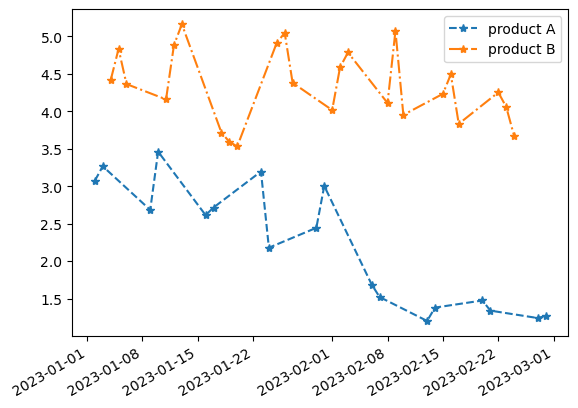

In [173]:
a = scores_a.plot(label='product A',marker='*',ls='--')
scores_b.plot(ax=a,label='product B',marker='*',ls='-.')
plt.legend()

with average statistics we can see how on average the footprint of product A has been reduced to half if its original value (as expected)

In [170]:
scores_a.resample('1M').mean()

2023-01-31    2.866259
2023-02-28    1.392874
Freq: M, dtype: float64

In [171]:
scores_b.resample('1M').mean()

2023-01-31    4.417944
2023-02-28    4.257201
Freq: M, dtype: float64